<a href="https://colab.research.google.com/github/dmachlanski/ncrm-causality-2021/blob/main/Day_2_CI_in_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install econml

     |████████████████████████████████| 3.0MB 4.0MB/s 
     |████████████████████████████████| 358kB 38.0MB/s 
     |████████████████████████████████| 133kB 32.2MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp37-cp37m-linux_x86_64.whl size=490501 sha256=e7697a61626a77528a78ce0b8b2fa1ccb39ac5d7fd064ab1eeb0cd81079f7c9a
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap
  Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [3]:
from econml.data.dgps import ihdp_surface_B
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
Y, T, X, expected_te = ihdp_surface_B()

y_train, y_test, t_train, t_test, x_train, x_test, te_train, te_test = train_test_split(Y, T, X, expected_te, test_size=0.2, random_state=1, stratify=T)

In [5]:
# X-Learner
xl = XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
xl.fit(y_train, t_train, X=x_train)

xl_te_in = xl.effect(x_train)
xl_te_out = xl.effect(x_test)

In [6]:
t_train_2d = t_train.reshape(-1, 1)
t_test_2d = t_test.reshape(-1, 1)

# Random Forest
rf = RandomForestRegressor()
rf.fit(np.concatenate([x_train, t_train_2d], axis=1), y_train)

rf_y0_in = rf.predict(np.concatenate([x_train, np.zeros_like(t_train_2d)], axis=1))
rf_y1_in = rf.predict(np.concatenate([x_train, np.ones_like(t_train_2d)], axis=1))

rf_y0_out = rf.predict(np.concatenate([x_test, np.zeros_like(t_test_2d)], axis=1))
rf_y1_out = rf.predict(np.concatenate([x_test, np.ones_like(t_test_2d)], axis=1))

rf_te_in = rf_y1_in - rf_y0_in
rf_te_out = rf_y1_out - rf_y0_out

In [7]:
def rmse(a, b):
    return np.sqrt(((a - b)**2).mean())

def ate_error(pred_te, true_te):
  return np.abs(np.mean(pred_te) - np.mean(true_te))

def pehe_error(pred_te, true_te):
  return rmse(true_te, pred_te)

In [8]:
xl_ate_in, xl_pehe_in = ate_error(xl_te_in, te_train), pehe_error(xl_te_in, te_train)
xl_ate_out, xl_pehe_out = ate_error(xl_te_out, te_test), pehe_error(xl_te_out, te_test)

rf_ate_in, rf_pehe_in = ate_error(rf_te_in, te_train), pehe_error(rf_te_in, te_train)
rf_ate_out, rf_pehe_out = ate_error(rf_te_out, te_test), pehe_error(rf_te_out, te_test)

In [9]:
results = []
results.append(['XL', xl_ate_in, xl_pehe_in, xl_ate_out, xl_pehe_out])
results.append(['RF', rf_ate_in, rf_pehe_in, rf_ate_out, rf_pehe_out])

cols = ['Method', 'ATE in', 'PEHE in', 'ATE out', 'PEHE out']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE in,PEHE in,ATE out,PEHE out
0,XL,0.006831,0.612278,0.038489,0.643703
1,RF,0.147609,0.889657,0.041462,0.689965


In [10]:
def mean_ci(data, ci=0.95):
  l_mean = np.mean(data)
  lower, upper = st.t.interval(ci, len(data)-1, loc=l_mean, scale=st.sem(data))
  return l_mean, lower, upper

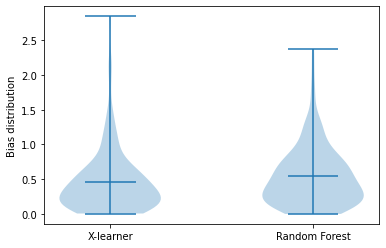

In [13]:
plt.violinplot([np.abs(xl_te_out - te_test), 
                np.abs(rf_te_out - te_test)
               ], showmeans=True)
plt.ylabel("Bias distribution")
plt.xticks([1, 2], ['X-learner', 'Random Forest'])
plt.show()

In [14]:
xl_ate_bounds = mean_ci(xl_te_out)
rf_ate_bounds = mean_ci(rf_te_out)

results = []
results.append(['XL', xl_ate_bounds[0], xl_ate_bounds[1], xl_ate_bounds[2]])
results.append(['RF', rf_ate_bounds[0], rf_ate_bounds[1], rf_ate_bounds[2]])

cols = ['Method', 'ATE mean', 'CI lower', 'CI upper']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE mean,CI lower,CI upper
0,XL,3.880738,3.736886,4.024591
1,RF,3.800787,3.597701,4.003873


In [15]:
np.mean(te_test)

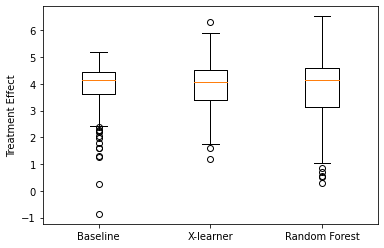

In [58]:
plt.figure()
plt.boxplot([te_test, xl_te_out, rf_te_out], labels=['Baseline', 'X-learner', 'Random Forest'])
plt.ylabel('Treatment Effect')

plt.show()

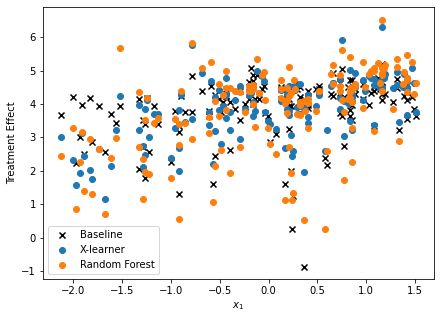

In [53]:
x_id = 1

plt.figure(figsize=(7, 5))
plt.scatter(x_test[:, x_id], te_test, color='black', marker='x', label='Baseline')
plt.scatter(x_test[:, x_id], xl_te_out, label="X-learner")
plt.scatter(x_test[:, x_id], rf_te_out, label="Random Forest")
plt.xlabel(f'$x_{x_id}$')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()